In [1]:
import librosa
import scipy
import glob
import soundfile as sf
from scipy.io import wavfile

# Track2

In [2]:
answer_dict_tmpinsample = {}

## read wav and segment with oracle vad + uem

In [23]:
uem_path = '/workspace/DATASET/server9_ssd/DIHARD3/LDC2020E13_Third_DIHARD_Challenge_Evaluation_Data_SCRUBBED/data/uem'
sad_path = '/workspace/DATASET/server9_ssd/DIHARD3/webrtc_sad'
eval_wav_out = '/workspace/DATASET/server9_ssd/DIHARD3/eval_wav'

In [24]:
uems = glob.glob(uem_path+'/*')
wavs = glob.glob(eval_wav_out+'/*')
sads = glob.glob(sad_path+'/*')

In [25]:
raw_wav_dict = {}

In [26]:
len(uems) == len(wavs)

True

In [27]:
len(sads) == len(wavs)

True

In [28]:
sad_dict = {}
for file in sads:
    label = file.split('/')[-1].split('.')[0]+'.wav'
    with open(file, 'r') as f:
        data = f.readlines()
    sad_dict[label] = data 

In [29]:
for file in wavs:
    label = file.split('/')[-1]    
    raw_wav_dict[label] = wavfile.read(file)[1]

In [30]:
answer_dict_tmpinsample = {}
for i in raw_wav_dict:
    perspk_dict_tmpinsample = {}
    sample_len = len(raw_wav_dict[i])
    sad_results = sad_dict[i]
    start, end = None, None
    for count, j in enumerate(sad_results):

        start = int(float(j.split('\t')[0]) * 16000)
        if end is not None:
            perspk_dict_tmpinsample[str(end)+'.'+str(start)] = 'silence'
        end = int(float(j.split('\t')[1]) * 16000)
        perspk_dict_tmpinsample[str(start)+'.'+str(min(end, sample_len))] = 'unknown'
        if end >= sample_len:
            break
    if end < sample_len:
        perspk_dict_tmpinsample[str(end)+'.'+str(sample_len)] = 'silence'
    
    answer_dict_tmpinsample[i] = perspk_dict_tmpinsample
            

In [31]:
answer_dict_tmpinsample['DH_EVAL_0001.wav']

{'0.1120': 'unknown',
 '1120.3520': 'silence',
 '3520.7520': 'unknown',
 '7520.8480': 'silence',
 '8480.29920': 'unknown',
 '29920.34240': 'silence',
 '34240.35360': 'unknown',
 '35360.41600': 'silence',
 '41600.54080': 'unknown',
 '54080.55520': 'silence',
 '55520.56960': 'unknown',
 '56960.58880': 'silence',
 '58880.62240': 'unknown',
 '62240.71680': 'silence',
 '71680.72800': 'unknown',
 '72800.74880': 'silence',
 '74880.132320': 'unknown',
 '132320.134080': 'silence',
 '134080.146720': 'unknown',
 '146720.152800': 'silence',
 '152800.154080': 'unknown',
 '154080.155680': 'silence',
 '155680.158720': 'unknown',
 '158720.160960': 'silence',
 '160960.175520': 'unknown',
 '175520.191840': 'silence',
 '191840.221920': 'unknown',
 '221920.222720': 'silence',
 '222720.224320': 'unknown',
 '224320.224960': 'silence',
 '224960.232000': 'unknown',
 '232000.238400': 'silence',
 '238400.239520': 'unknown',
 '239520.244320': 'silence',
 '244320.268640': 'unknown',
 '268640.270240': 'silence',
 

In [32]:
uems_dict = {}
for i in uems:
    with open(i, 'r') as f:
        uem_lines = f.readlines()
    uem_segs = []
    for j in uem_lines:
        start, end = float(j[:-1].split(' ')[-2]), float(j[:-1].split(' ')[-1])
        start, end = int(start * 16000), int(end * 16000)
        uem_segs.append(str(start)+'.'+str(end))
        
    uems_dict[i.split('/')[-1].split('.')[0]+'.wav'] = uem_segs

In [33]:
uems_dict

{'DH_EVAL_0050.wav': ['0.6646176'],
 'DH_EVAL_0007.wav': ['0.9599232'],
 'DH_EVAL_0217.wav': ['0.6069312'],
 'DH_EVAL_0128.wav': ['0.5810704'],
 'DH_EVAL_0160.wav': ['0.10016000'],
 'DH_EVAL_0190.wav': ['0.489952',
  '504080.997920',
  '1008048.1733984',
  '1742656.2238256',
  '2245056.3592656',
  '3601872.4185184',
  '4194928.4691232',
  '4701712.5184000'],
 'DH_EVAL_0086.wav': ['0.2488800'],
 'DH_EVAL_0102.wav': ['0.219456',
  '231312.565968',
  '575520.852832',
  '865936.2161600',
  '2164464.3092176',
  '3095760.4588800'],
 'DH_EVAL_0168.wav': ['0.9599232'],
 'DH_EVAL_0175.wav': ['0.9730400'],
 'DH_EVAL_0104.wav': ['0.4444336', '4448016.5200000'],
 'DH_EVAL_0116.wav': ['0.2856240'],
 'DH_EVAL_0027.wav': ['0.9769600'],
 'DH_EVAL_0223.wav': ['0.278304',
  '287264.479552',
  '499872.531024',
  '540384.1136288',
  '1146624.1210576',
  '1226544.1291904',
  '1307376.1390432',
  '1399584.1426112',
  '1437216.4875904'],
 'DH_EVAL_0010.wav': ['0.5805440'],
 'DH_EVAL_0029.wav': ['0.9599232'],

In [34]:
# seg use uems on vad results
answer_dict_tmpinsample_uem = {}
for i in answer_dict_tmpinsample:
    perspk_dict_tmpinsample_uem = {}
    perspk_dict_tmpinsample = answer_dict_tmpinsample[i]
    uem_segs = uems_dict[i]
    count = 0
    
    vad_segs = list(perspk_dict_tmpinsample.keys())
    for j in range(len(vad_segs)-1):
        assert float(vad_segs[j]) < float(vad_segs[j+1])
    if len(uem_segs) > 1:
        for j in range(len(uem_segs)-1):
            assert float(uem_segs[j]) < float(uem_segs[j+1])
            
    uem_segs_int = [[int(k.split('.')[0]), int(k.split('.')[1])] for k in uem_segs]
    
    false_count = 0
    for m in vad_segs:
        start, end = m.split('.')
        start, end = int(start), int(end)
        indicator = False        
        for n in uem_segs_int:
            if start>=n[0] and end<=n[1]:
                perspk_dict_tmpinsample_uem[m] = perspk_dict_tmpinsample[m]
                indicator = True
                break
            else:
                pass
        if not indicator:
            false_count += 1
    answer_dict_tmpinsample_uem[i] = perspk_dict_tmpinsample_uem
    print(false_count)
    

0
0
0
0
1
0
1
1
0
2
0
0
0
0
37
0
2
1
0
16
0
0
0
0
0
0
1
0
0
0
0
12
0
0
1
1
0
0
0
0
0
6
0
3
0
0
1
0
0
0
0
0
0
2
153
1
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
33
0
0
0
0
0
1
0
0
0
0
0
0
0
9
3
0
0
0
0
1
2
0
0
0
0
0
0
5
1
0
8
1
1
15
38
1
8
0
0
0
0
0
0
0
0
0
0
1
1
0
0
30
0
0
0
0
0
0
0
0
0
0
0
0
13
0
13
0
26
1
0
0
0
0
3
0
5
0
17
1
1
0
0
0
0
4
0
21
0
4
0
4
0
0
1
0
29
10
0
0
0
26
0
0
0
1
0
0
0
0
0
1
1
0
0
29
0
0
0
0
1
0
0
12
0
0
0
1
7
0
3
1
1
0
0
0
0
0
15
0
0
0
0
0
0
0
9
1
0
0
0
11
29
1
1
0
0
0
0
0
0
2
0
1
0
0
0
0
0
0
0
7
0
0
9
0
26
0
27
0
0
0
0
0
0
0


In [35]:
answer_dict_tmpinsample = answer_dict_tmpinsample_uem

## segment to 1.5s

In [36]:
seg_len = int(1.5 * 16000)
seg_hop = int(0.75 * 16000)

In [37]:
seg_len

24000

In [38]:
seg_hop

12000

In [39]:
answer_dict_tmpinsample2 = {}
for i in answer_dict_tmpinsample:
    perspk_dict_tmpinsample = answer_dict_tmpinsample[i]
    perspk_dict_tmpinsample_seg = {}
    for j in perspk_dict_tmpinsample:
        if perspk_dict_tmpinsample[j] == 'unknown':
            start, end = j.split('.')
            start, end = int(start), int(end)
            if (end - start) <= seg_len:
                perspk_dict_tmpinsample_seg[str(start)+'.'+str(end)] = 'unknown'
            else:
                start_tmp = start
                end_tmp = start + seg_len
                assert end_tmp < end
                while(True):
                    if (end_tmp+seg_hop) > end:
                        end_tmp = end                    
                        perspk_dict_tmpinsample_seg[str(start_tmp)+'.'+str(end_tmp)] = 'unknown'
                        print(end_tmp-start_tmp)
                        break
                    else:
                        perspk_dict_tmpinsample_seg[str(start_tmp)+'.'+str(end_tmp)] = 'unknown'
                        start_tmp = start_tmp + seg_hop
                        end_tmp = end_tmp + seg_hop
                        print(end_tmp-start_tmp)
        elif perspk_dict_tmpinsample[j] == 'silence':
            start, end = j.split('.')
            start, end = int(start), int(end)
            perspk_dict_tmpinsample_seg[str(start)+'.'+str(end)] = 'silence'
        else:
            raise Exception
    answer_dict_tmpinsample2[i] = perspk_dict_tmpinsample_seg

24000
24000
31680
32320
24000
35840
24000
24000
32320
25440
24000
32640
29760
25440
24000
24000
24000
29120
24000
24000
26720
24000
30560
24000
32640
33440
24000
24641
24480
24000
24000
24000
24000
24000
24000
26560
24000
24800
25920
24000
24000
24000
33280
34080
34400
31360
24000
25760
34400
25600
24000
30880
24000
30240
24000
24160
24000
24000
24000
24000
24160
24000
24000
24320
26080
24000
24000
24000
33760
33760
24000
32960
26880
24000
31680
24160
27360
28000
24000
31040
24320
24000
28160
24000
24000
26240
31040
28640
24000
24000
24000
25120
24000
33280
31680
29920
24000
30880
24000
31200
31520
24000
31360
24000
24000
24000
34080
24000
24640
33600
27360
24000
29920
24000
27680
29440
24000
24000
25280
24000
24480
24000
24000
27840
24000
35680
24000
29280
31360
24000
24000
24000
24640
35200
24000
24000
27360
24000
32960
32640
24000
24000
24000
35360
24000
24800
33440
32160
24000
29280
34560
24000
24000
25280
34080
29600
29760
28480
33760
32640
24000
31200
24000
31680
24000
25440
2400

32000
24000
31360
24000
24000
31040
28000
26880
31040
33120
34880
24320
26080
31040
24000
24000
24480
24000
28960
24000
24000
24000
24000
35520
29601
35840
24320
25600
24000
29440
24000
24000
32640
24000
28960
24000
34560
24160
24000
24000
32480
27840
26880
24000
24000
24000
24000
24000
28640
27680
24000
24000
28320
24000
24000
34720
34080
24000
24000
24000
26240
24000
24000
29120
24000
28320
30080
24000
25440
24000
24160
24320
29440
24000
24000
30080
25440
28320
24000
32640
25440
27360
24000
24960
28320
26880
24000
27040
28320
24000
25280
24000
24000
24000
24000
24000
24000
24000
27680
24000
24000
24000
24000
30560
24000
24800
24000
24000
24000
29120
24000
24000
28480
24000
24000
24000
24000
25280
35360
25920
24000
24000
24000
24000
24000
24000
24000
26240
31680
24000
24000
30400
24000
24000
24320
24000
24640
28960
24000
24000
28960
34080
24000
24000
33440
24000
24000
29280
24000
24000
24000
29600
24000
24800
27200
24000
24000
24000
24000
24000
24000
24000
24000
24000
24960
32800
3200

24800
31520
31840
34080
30880
26400
24000
31040
24000
24000
24000
24000
25600
35040
24000
24000
24000
24000
24000
24000
26400
24000
31680
33920
35840
32320
24000
29600
24000
33440
24000
24800
24000
24000
33760
24000
24000
24000
24000
24000
24320
24000
24000
24000
24000
33760
31840
24000
24800
24000
24000
24000
24000
24000
27680
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
28640
24000
24320
30240
24000
24000
24000
24000
31360
24000
24000
24640
24000
24000
24000
24000
24000
26880
24000
30720
24000
30560
24000
25920
24640
33440
24000
27360
28960
24000
26400
34720
24000
24000
24000
24000
24000
24000
24000
24000
24000
29760
24000
24000
24000
24000
24000
24000
24000
32320
24000
24000
24000
24000
29920
24000
24000
24000
24000
24000
24000
24000
35040
24480
24000
34720
24000
24000
24000
24000
24000
24000
24000
24000
24000
30240
24000
27680
24000
24000
24000
24000
27520
24000
24000
24000
24000
24000
24000
34400
24000
24000
24000
24000
24000
35040
24000
24000
24000
24000
2400

33760
24000
24000
24000
24000
31360
24000
24000
24000
24000
27520
32000
24000
28000
24000
35520
24000
24000
33920
24000
31840
24000
24000
24000
24640
24000
24000
24000
24000
24800
24000
35200
24000
24000
33920
24000
24000
24000
30400
24000
27360
24320
24000
30240
35360
24000
24000
29760
24000
32480
24160
24800
29440
24000
24000
32000
33440
24000
25280
24000
24000
24640
24000
33120
27360
24000
28480
26560
30240
24000
24000
27520
24000
24480
28320
26880
24000
24000
24000
24000
24000
24000
24000
25280
25760
30080
27840
24000
24000
24000
27040
24000
34240
24000
33280
24000
24000
24000
29600
24000
24000
24000
26560
31360
28160
24000
24000
24000
25280
24640
24000
34880
24000
32160
24000
26720
24000
26560
24000
33760
28640
24000
24000
24000
34240
31200
24960
26080
27360
29920
30400
35200
24000
28000
24000
33600
32000
32160
24000
24320
24000
30560
26560
24960
24000
24000
32481
24000
29600
24000
24000
24960
24000
33280
24000
24000
25280
33920
24000
34560
27520
24000
33280
25440
31840
26720
3088

24000
24000
24000
24000
24000
28160
25440
32160
24000
24000
25440
28000
27680
24480
25120
24000
29920
29280
28640
24000
24000
24000
24000
29920
24000
25600
32000
30560
24800
24000
24000
24000
34560
34080
32000
24000
24000
24000
25120
24000
30560
24000
31040
24000
24000
30400
24000
24000
24000
24000
33440
24000
24000
33760
24000
26240
24000
24000
35680
24000
24000
30720
27360
24000
35520
25280
32320
24000
24000
27840
24000
31040
24000
24000
24000
24000
24000
24000
25600
24000
25280
24000
24000
24000
24000
34240
24000
24000
24000
24000
28320
32320
35520
24000
25920
24000
24000
24000
24000
33120
24000
24000
33280
24000
24000
33280
26880
24000
24000
33440
24000
24000
24000
24000
24000
24000
24000
24000
29439
24000
24000
26240
28000
24960
24000
31040
24000
31520
29280
24000
24000
24000
24000
30560
24000
24000
24000
24000
28640
24000
24000
27520
24000
24800
24000
32000
24000
30400
24800
24000
24000
34400
24000
24000
24000
34560
33440
27200
24000
24000
24000
24000
24800
27360
24000
24000
2400

33280
24000
24000
24160
27680
29440
27360
24000
24000
24000
24000
26240
24000
29120
27360
31520
33920
24000
24000
26080
27040
33760
24160
24000
30720
28320
28640
34400
26880
24000
35360
27520
30880
24000
24000
24000
24000
24800
24000
26400
28160
28160
24000
24000
24000
24000
26561
24000
28320
26240
24000
32000
24000
25760
31680
34720
35200
24000
34400
24000
28000
29600
29280
24000
32960
24000
24000
31680
24000
24000
33760
24000
24000
24160
24480
26560
26560
24000
24000
28160
24000
26400
24000
25440
26240
24000
32160
34400
24000
30720
24000
24000
24000
24000
27360
28480
31520
25920
24000
28800
31360
26560
31680
24000
35680
24000
34880
24000
24000
24000
24000
24000
30880
24000
24000
24000
25440
24000
24000
24800
24000
24000
33920
25120
32960
24000
24000
24000
24480
24000
24000
24000
32000
24000
34240
24640
24000
24000
24000
24000
35040
24000
34400
24000
29600
29920
30720
24000
24000
32800
24000
34720
31679
28640
24000
24000
32320
24000
34240
35680
26080
26720
27680
24000
24320
31360
2896

28640
24000
27200
32640
35360
28800
26880
27680
24000
24000
25760
24000
35200
35360
24000
24000
24000
24000
24000
31360
26720
28160
24000
29120
24000
32960
24000
27840
24000
24000
24000
31040
33920
24000
24000
24160
34560
24000
33920
24000
24000
24000
24000
24000
30080
24000
24000
31040
27360
32320
31680
24000
24000
24000
24320
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
32000
24000
34880
24000
27840
24000
33920
32000
24000
24000
29280
24000
24000
24000
24000
24000
24000
24320
24000
24000
33440
24000
27039
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
26241
26080
24000
24000
24000
24000
24000
24000
24000
24000
30240
33760
24000
28320
28320
24000
24000
33440
24000
24000
24000
33280
24000
24000
24000
24000
24000
24000
24000
34400
33760
24000
24000
24000
24000
24000
31520
24000
24000
24000
24000
24000
24000
28320
24000
27840
24000
24000
26400
24000
24000
29440
24000
25920
24000
35360
24000
24000
24000
24000
24000
24000
24000
24000
35360
2400

33760
24000
32640
24000
30880
24000
24000
24000
30560
24320
24000
28000
29440
35520
24000
25760
24000
30080
24000
33920
34400
31200
24000
32160
24000
24000
24000
30560
30880
24000
34560
24000
28480
24000
30400
24000
24160
24000
34720
34880
26720
24000
24000
33920
33760
27040
24000
25440
27040
25600
24000
24000
25120
30240
26880
24000
26720
28480
31520
24000
29120
24000
24000
25120
31680
29120
24000
24000
25920
24000
24000
31520
30240
25760
27840
24320
24000
24800
24000
25440
27040
24000
25120
24000
24160
32800
24000
25760
32640
28160
26560
24000
24000
32640
24000
24000
27200
27200
31680
32000
27040
32000
26400
33920
26880
30880
24000
28640
30400
31840
28800
27520
30720
24000
24000
28640
28960
25760
24000
24000
30720
30240
27360
29120
32320
29440
29120
24000
24000
24000
24000
26080
24000
24000
24000
26560
24000
27360
24000
27360
24000
32800
24000
24000
24000
24000
24000
24000
24000
24000
24000
33920
24000
24000
30240
24000
24480
24000
24000
24000
24000
24000
24000
29600
24000
24000
2400

24000
30240
34560
24000
24000
24000
26400
30400
24000
24000
24000
26400
24000
24000
24000
29760
34240
24000
35200
24000
24000
30400
30560
27200
35040
35200
31840
24000
24000
24000
24000
34560
24640
24000
24640
30240
24000
24000
24000
24000
26720
24000
24320
24480
24000
24000
33600
24000
24000
24000
24000
24000
25120
24000
24000
24480
35520
24000
35680
24000
24480
27520
24000
24000
33280
32160
24000
32640
24000
27840
24000
26560
24000
27040
24000
24000
24000
33440
33920
34560
28800
33760
24000
29600
24000
32800
24000
24000
30720
24000
24000
24000
24000
24000
29920
32800
35840
24000
33600
24000
25280
24000
35520
24000
24000
28160
24000
27840
24000
24000
24000
29120
24320
30560
26080
24000
33440
24000
26080
24640
24800
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
25760
28800
27360
34880
24000
24000
24000
29280
28800
24000
24000
34240
29120
24000
25440
29120
24000
24000
32480
24000
24000
24000
33120
35200
32160
24000
30720
25600
24000
24000
24000
26240
2400

24000
24000
24480
31520
24000
24000
34880
24000
24000
24000
24000
27200
24000
24000
30400
24000
24000
29760
24000
24000
24000
34720
24000
24000
25280
24000
24000
34560
24000
24000
34400
34720
24000
24000
24000
24000
26400
24000
27200
24000
24000
24000
30081
24000
26880
24640
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
31200
34400
33120
24000
30560
24000
24000
24000
24000
24000
24000
33600
24000
24000
25280
33120
26880
24800
24000
24000
31360
33600
26400
24000
24000
32640
32160
24000
24000
24000
24000
24000
24000
24000
24000
24480
24000
24000
28480
24000
24000
24000
24000
26080
24000
24000
24000
35680
24000
24000
24000
32160
24000
24000
31040
24000
24000
24000
24000
24000
24000
27520
24000
24000
24000
24000
28160
31200
24000
24000
24000
35520
24000
24000
24000
24000
24000
24160
24000
31200
24000
28160
26720
34720
29600
24000
24000
26400
24000
24000
24000
25760
24000
24000
32640
31840
34720
24000
26240
24000
29440
31520
24000
24000
24320
24000
24000
26720
2400

24000
29120
24000
32800
32480
24000
24000
31840
24000
24000
24000
24000
24000
24000
30720
24000
24000
28640
24000
24000
24000
24000
24000
35040
24000
24000
24000
24000
29600
24000
24000
24000
24000
24000
24000
24000
24160
24000
34560
24000
24000
24000
28000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
35520
24000
24000
31520
24000
27520
30080
31520
24000
24000
24000
24000
30240
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
35200
24000
24000
32000
24000
24000
30560
24000
24000
24000
24000
24000
24320
24000
24000
24000
24000
24000
24000
24480
33440
24000
24000
28800
24000
24000
24000
32800
24000
24000
24000
24000
24000
24000
25920
24000
34400
24000
24000
24000
24000
29600
24000
24000
24000
24000
24000
24000
24000
24000
24000
35360
24000
24000
24000
31040
32160
24000
24000
24000
30720
24000
24000
24000
24000
33120
24000
24000
24000
26880
24000
24000
24000
24000
24000
24000
24000
24000
24000
28320
24000
24000
2400

34720
24000
24000
24640
24000
24000
24000
24000
28800
24000
29440
25120
24000
27040
24000
26080
24480
32960
27840
24320
32480
24320
24640
31680
29920
24000
24320
33600
34240
24000
26080
24000
30080
28960
28320
25600
24000
24000
24000
30880
35360
24960
33760
29280
24000
28320
27520
24800
24000
24000
35840
28480
26080
26720
25920
24000
32640
28800
24000
24001
29280
29600
24320
24000
24000
32000
24000
24000
24000
25600
24000
35200
24640
35520
24000
35200
34560
24000
26880
30240
24000
26080
24000
30880
30080
26720
29759
24000
24000
28800
35200
24320
27520
31840
31840
24000
24000
33600
35520
32960
27200
24000
24000
24000
24000
24000
34560
24000
24000
24000
26400
27200
28480
30400
24000
24000
24000
29600
24000
35520
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
31040
24000
24000
24000
24000
24000
24000
31840
24000
28640
24000
32480
24000
24000
24000
24000
24320
30080
24320
24000
24000
24000
24000
24000
24000
24000
27840
24000
28160
28640
24000
24000
24000
31680
2400

24000
24000
24000
29920
24000
24000
24000
24000
24000
24000
26720
24000
24000
30720
24000
24000
24000
29760
24000
24000
24000
29600
24000
24000
24000
28320
26880
24160
24000
24000
24000
29280
24000
28000
24000
35040
24000
24000
30560
24000
35360
24000
30560
24480
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
30240
24000
24000
24000
24800
24000
28000
24000
32800
31360
24000
24000
24000
24000
24000
34240
24640
24000
25440
28640
24480
24000
32800
24000
28160
24000
24000
31040
24000
24000
24160
24800
26080
24000
26080
24000
26080
27520
25760
29600
24000
24000
31200
27040
24960
24000
24000
24000
35360
24000
30720
24000
25120
24480
24000
24000
31200
24000
24000
24000
24000
24000
24000
35360
24000
24000
24000
25760
24000
24000
24000
27200
34080
26240
31520
24000
29280
24000
27360
24000
34240
25760
24000
24000
24000
24000
29760
24000
24000
24000
28320
24000
24960
24480
24480
31680
24000
24000
27680
24000
24000
24000
24000
24640
24000
24000
24160
26720
24000
24000
24000
27200
2400

32800
24000
26720
24000
24000
25600
29600
24000
26080
24000
34240
30400
24000
26880
26080
24000
32480
24000
24000
24000
24000
24000
25280
24000
29120
24160
24000
31520
24000
25920
30240
24000
24000
25760
24000
24000
24000
29600
24000
35040
24000
24000
24000
24000
33600
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
30720
24000
29760
24000
28320
24000
32000
27840
28480
27040
24000
24000
24000
24000
26240
24320
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
26080
27840
24000
24000
24000
24000
29440
24000
24000
24000
24000
24000
24000
33440
24000
24000
24000
34560
24000
26720
24000
28800
30080
24000
24000
24000
24000
34080
32000
24000
34400
24000
25441
35680
29120
24000
24000
24000
31200
24000
24000
33920
27040
24000
24000
24000
28320
24000
26240
24000
32320
35520
30560
34080
35520
24000
24000
30080
28800
24000
24000
32320
30400
28320
24000
26080
26240
27840
31360
24000
28960
24000
24000
26240
32960
30880
24000
2400

24000
24000
35680
24000
25920
24000
24000
24480
24000
24000
33600
24000
24000
32160
24000
28160
26880
24160
24000
25920
24000
24000
24000
25600
24000
24000
29760
24000
35680
24000
33280
24000
26720
24000
32480
31200
24000
24000
24000
24000
32640
24000
27841
24000
33760
28480
24160
27840
27520
29760
33920
24000
24000
28800
24000
24000
35360
24000
25440
29280
24000
30240
24000
25440
24000
24000
26560
24000
26560
24000
32000
24000
24960
24000
24000
24000
27200
29760
24960
26880
32160
24000
24000
25280
30720
24000
33440
26240
33440
32640
30080
24000
24000
28320
24640
24000
35840
24000
33760
25440
24000
24000
24000
24000
24160
31680
24000
25920
24000
24000
27840
35840
24000
31680
27200
24000
28320
24000
28160
25920
24000
34240
25280
24000
29600
24000
26720
24000
32320
28160
24000
27680
24000
35840
24000
28480
31360
29121
31840
24000
25280
27041
34720
24000
32320
24000
24000
24000
24000
30560
24000
24000
29600
28640
28320
24960
24000
32800
24000
32640
24000
25440
35360
31040
34080
24000
2608

24000
24000
28000
24000
24000
24000
26240
24000
24000
35520
24000
24000
32320
24000
24000
24000
24000
24000
24000
31040
24000
26080
28640
24000
24000
32640
24000
24000
24000
24000
24000
24000
24000
24000
24000
24480
24000
24000
24000
24000
29440
24000
24000
24000
28000
24000
24000
24000
29600
24000
24000
25120
30880
30400
24000
24000
24000
24000
24160
28640
25280
24000
24000
29760
24000
33600
24960
24000
29600
24000
33920
24000
24000
24000
24000
24000
24000
24000
24000
24000
35840
24000
24000
26080
24000
24000
24000
24000
24000
24000
24000
24800
29920
28480
24000
24000
24000
24000
24000
24000
24480
32320
24000
24000
24000
24000
24000
24000
24000
35200
24000
30560
29120
24000
24959
31201
24000
29600
24000
24000
24160
25920
24000
29760
25440
35840
24000
35360
24000
24000
24000
24000
24000
26240
24480
24000
24000
24000
28480
24000
24000
24000
24000
26560
35200
24000
24000
24000
24000
30880
24000
29120
30880
24000
28800
24480
33120
32800
24000
24000
24000
24000
24000
24000
24000
24000
3040

24000
26880
24000
27680
24000
26080
26080
29920
34720
24000
24000
24000
24480
24000
31520
24000
24000
24000
24000
24000
24000
29600
24000
24000
34560
24000
24000
24000
24000
24000
24000
31040
24000
24640
24000
24000
28960
24000
24000
24000
24000
24000
24000
24000
34720
24000
24000
24000
26560
24000
24000
24000
27840
24000
24000
33600
24000
24000
24000
24000
24000
29760
24000
30560
24000
24000
27840
24000
27360
24000
24000
24000
24000
24000
24000
24000
24000
24000
28640
25600
24000
24000
24000
24000
26080
24000
24000
24000
24000
24000
24000
30240
24000
24000
28000
28160
24000
34880
34240
28800
28000
24000
24640
24000
24000
25280
24000
30240
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
30400
24000
24000
24000
24000
24000
24480
24000
24000
24000
28000
25440
24000
24000
24000
24000
35840
24000
35840
24000
24000
24000
24000
24000
26880
24000
24000
24000
34880
26240
24000
24000
24000
24000
24000
24000
24000
24000
26560
24000
24000
24000
24000
32800
24000
24000
2400

29760
29760
27680
35200
24000
35200
30080
24000
24000
25760
24000
24000
24000
24000
29760
24000
25600
24000
28160
29920
24000
27040
24000
24000
32160
24000
24000
24000
24000
24000
28000
26240
24000
24000
28160
24000
28640
32480
30880
31040
24000
24000
24000
24000
24000
24000
30720
24000
24000
24160
31680
32640
24000
26080
24960
24640
24000
24000
24000
24000
24000
24000
24000
24000
33760
32000
24000
24000
24800
35360
24000
29120
24000
24000
24000
33120
24000
24000
24000
24320
26400
24000
24000
24000
26240
24000
27040
34720
29440
33600
24000
24000
31360
24800
24000
24960
24000
25120
25440
24000
24000
33440
24000
24000
34720
24000
25760
25920
31360
30080
24000
24000
25920
25920
24000
24000
24000
29920
28160
34720
24000
29440
24000
24000
24960
24000
24000
24000
24000
24000
33600
34240
24000
27200
29920
24000
24000
33440
24000
24000
24000
33920
24000
32960
24000
24000
29600
24000
26400
24000
24000
33280
32160
24000
24000
33120
35200
27520
31360
29120
24000
29600
24000
24000
24000
24000
3423

30080
24000
24000
30400
33920
28160
25440
28320
24000
28640
34560
24000
31520
24160
24000
24000
24000
24000
24000
24160
32959
29920
24000
28801
31040
25121
24000
24000
33440
24000
24000
24000
24000
24000
24000
24000
24000
24000
24960
24000
24000
25440
34240
24000
24000
24000
30080
27840
24000
24000
25760
24000
31680
28000
24000
24000
29600
24000
28800
24000
24000
27200
24000
24000
24000
35840
30560
32000
26560
25120
24000
26240
24000
24000
24000
24320
24000
24000
24000
27040
26400
24000
24000
24000
34400
24000
24000
29440
24000
24000
32800
28640
24000
24000
24000
24000
25920
24000
24320
28160
24000
24000
34080
24000
24800
31520
24000
24000
24000
24000
24000
29920
24000
27680
24000
24000
24000
24000
24000
28960
24000
28640
35840
29760
34080
24000
24000
24000
25920
24000
24000
24000
25120
26080
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
35360
24000
24000
24000
24000
24000
24000
24000
28160
24000
28160
24000
32160
26080
24000
24000
24000
31200
28960
30720
24480
2400

24000
24000
24160
34080
26400
25280
34400
29920
30880
26080
35840
27200
24800
29600
24480
24000
25120
24000
33600
26880
24000
24000
25280
24000
24000
24000
24000
24000
24000
24000
27520
24000
24000
24000
24000
24000
24000
24000
24160
25120
24000
24000
30080
24000
35040
32640
24320
27200
24000
26080
24000
33280
33600
34560
24000
24000
26080
24000
25280
31360
24800
31200
24000
24000
27520
30240
28479
27520
24000
32160
31360
24000
24000
24000
26400
26560
24000
24000
24000
28800
24000
24000
26880
24000
28800
24000
28480
28000
34560
24000
29920
24000
24000
24000
24000
33600
32800
24000
24000
25440
28480
35360
27200
25440
24000
32320
24000
24000
32160
24000
24000
30400
24000
24000
33120
24000
28160
33120
24000
24000
33440
24000
24000
24000
24000
24000
24000
31040
33600
32320
24000
26720
24000
30720
34080
24000
24000
32480
27360
24000
24000
35840
29760
24000
24000
24000
33920
24000
29440
24000
24000
24320
24000
24000
24000
24000
24000
33600
29600
24000
24000
24000
24000
25280
31680
24800
2496

24000
30720
24000
28159
24000
28480
24000
24160
24000
24000
24000
24000
31680
24000
24000
24000
25600
30560
30880
32320
34720
24000
24000
24000
24000
24000
29440
31360
24000
26720
26560
24000
29760
24000
30720
24000
24160
24000
24000
24000
28640
26400
24000
24000
24000
35680
24000
32640
24000
24000
34720
24000
24000
31680
24000
24000
30880
27360
33600
24000
24000
29439
32800
24000
24000
30240
28640
26880
24000
24000
26240
24000
24000
35360
25280
24000
24000
24000
30880
24000
29760
28640
24000
34240
24000
24000
28160
24000
24000
24000
24000
32480
31680
24000
24000
24000
24000
26720
27840
35840
24000
31360
24000
26720
30560
34400
35200
24480
24800
31840
24000
32160
24000
24000
24000
25760
24000
31360
32960
24000
24000
31360
24000
24000
24000
28480
34720
32320
27520
25760
34560
24000
24960
24000
24000
24000
24640
24000
28000
24000
30080
27360
24480
30080
33760
28480
24160
24000
24000
27520
24000
31360
27040
26560
24000
24000
33120
26880
24000
24000
24000
24000
24000
24000
24000
27680
2400

28160
24000
24000
24000
24000
35360
24000
24000
28800
24000
29760
24000
24000
24000
24000
24000
30400
27360
24000
30240
24000
24000
24000
25600
24000
32800
24000
24000
28640
32640
26880
27680
24000
33440
34720
24000
27520
24000
24000
24000
30560
24000
24000
28320
25280
24000
24000
28800
32960
29440
24160
31200
24000
31520
35680
24000
24000
30080
24000
29280
24000
24000
24000
32640
24000
24000
28480
24000
25280
27200
24000
26400
24000
27200
24000
24000
24000
31520
29600
24000
24000
24000
27680
24000
26880
24000
24000
24000
24000
28480
24000
24000
24000
24000
24000
24000
29280
24000
24000
24000
24000
24000
30400
24000
24000
24000
26080
24160
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24000
24320
24000
35520
24000
31520
24000
24000
24000
24000
24000
24000
25440
33599
24000
24000
24000
28320
24000
24000
24000
24000
32640
24000
24000
24000
27360
26720
24000
24000
24000
24000
24000
24000
29760
24000
33760
24000
24000
24000
24000
24000
24000
24000
24000
26080
24000
3232

24000
24640
28000
24000
34880
24000
24000
30400
24000
24000
24000
24000
24000
24000
30560
30720
35200
24000
33760
24640
32000
24000
31520
24000
24000
24000
24000
27680
27200
33440
28480
24000
24000
35680
34240
24000
32960
24800
24000
24000
29920
24000
24000
32640
24000
24000
24000
24000
24000
26560
35840
24000
24000
24000
34240
24000
24000
29600
24000
24000
24000
24000
26240
24000
29920
24000
24000
24000
24000
24000
24000
35520
27840
24000
30560
24000
24000
24000
24000
24000
24000
24000
24000
24000
31520
24000
28960
24000
24000
30720
24000
35520
24000
24000
24000
27520
24000
25440
31520
24000
24000
24000
24000
24000
26560
28961
24000
24000
24000
28160
24000
24000
24000
24000
35520
24000
24000
24000
24000
31680
24000
24000
24000
26880
33760
24000
24000
24000
24000
24000
31360
24000
31040
24000
31360
24000
24000
24000
24000
24000
24000
26720
24000
24800
24000
33920
24000
30560
28320
30560
24960
24160
24000
27520
24800
24000
25440
25120
27680
26720
27680
24000
24000
24000
24000
32960
3520

In [40]:
answer_dict_tmpinsample2['DH_EVAL_0001.wav']

{'0.1120': 'unknown',
 '1120.3520': 'silence',
 '3520.7520': 'unknown',
 '7520.8480': 'silence',
 '8480.29920': 'unknown',
 '29920.34240': 'silence',
 '34240.35360': 'unknown',
 '35360.41600': 'silence',
 '41600.54080': 'unknown',
 '54080.55520': 'silence',
 '55520.56960': 'unknown',
 '56960.58880': 'silence',
 '58880.62240': 'unknown',
 '62240.71680': 'silence',
 '71680.72800': 'unknown',
 '72800.74880': 'silence',
 '74880.98880': 'unknown',
 '86880.110880': 'unknown',
 '98880.132320': 'unknown',
 '132320.134080': 'silence',
 '134080.146720': 'unknown',
 '146720.152800': 'silence',
 '152800.154080': 'unknown',
 '154080.155680': 'silence',
 '155680.158720': 'unknown',
 '158720.160960': 'silence',
 '160960.175520': 'unknown',
 '175520.191840': 'silence',
 '191840.221920': 'unknown',
 '221920.222720': 'silence',
 '222720.224320': 'unknown',
 '224320.224960': 'silence',
 '224960.232000': 'unknown',
 '232000.238400': 'silence',
 '238400.239520': 'unknown',
 '239520.244320': 'silence',
 '24

In [41]:
seg_count = []
for i in answer_dict_tmpinsample2:
    dic = answer_dict_tmpinsample2[i]
    count = 0
    for j in dic:
        if dic[j] == 'unknown':
            count += 1
    seg_count.append(count)

In [42]:
max(seg_count)

1507

In [43]:
min(seg_count)

40

## extract embs

In [44]:
import sys
import os
import importlib
import torch
import numpy
import torch.nn.functional as F

In [45]:
sys.path.append('/workspace/GREAT_ASV_system/train_dist')

In [46]:
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

In [128]:
# from DatasetLoader import loadWAV

In [47]:
SpeakerNetModel = importlib.import_module('models.'+'EPACA-TDNN').__getattribute__('MainModel')

In [48]:
# EPACA-TDNN
S = SpeakerNetModel(n_mels=40, nOut=192, spec_aug=False)

EPACA-TDNN.py, Embedding size is 192, Channels 1024, Spec_aug False.


In [49]:
model_path = '/workspace/LOGS_OUTPUT/tmp_logs/train_logs_201120/multi_gpu_epaca_tdnn/model/model000000067.model'

In [50]:
S.cuda()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 1024, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(128, 128, kernel_size=(3,), 

In [51]:
loaded_state = torch.load(model_path, map_location="cuda:0")

In [52]:
self_state = S.state_dict()

for name, param in loaded_state['model'].items():
    origname = name
    if name not in self_state:
        name = name.replace("__S__.", "")

        if name not in self_state:
            print("#%s is not in the model."%origname)
            continue

    if self_state[name].size() != loaded_state['model'][origname].size():
        print("#Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state[origname].size()))
        continue

    self_state[name].copy_(param)

#__L__.W is not in the model.


In [53]:
S.eval()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 1024, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(128, 128, kernel_size=(3,), 

In [54]:
def audio2emb(audio):
    audiosize = audio.shape[0]
    max_audio = seg_len
    if audiosize <= max_audio:
        shortage    = max_audio - audiosize + 1 
        audio       = numpy.pad(audio, (0, shortage), 'wrap')
    audio = audio[None, :].astype(numpy.float)

    inp1 = torch.FloatTensor(audio).cuda()

    ref_feat = S.forward(inp1).detach().cpu()
    return ref_feat

In [55]:
spks_matind2time = {}

In [56]:
for i in answer_dict_tmpinsample2:
    perspk_dict_tmpinsample_seg = answer_dict_tmpinsample2[i]
    perspk_matind2time = {}
    count = 0
    for j in perspk_dict_tmpinsample_seg:
        if perspk_dict_tmpinsample_seg[j] == 'unknown':
            perspk_matind2time[count] = j
            count += 1
    spks_matind2time[i] = perspk_matind2time
    print(count)

400
1450
623
533
451
586
47
242
608
319
560
602
1029
601
323
627
346
580
449
273
551
553
1294
616
561
586
642
756
677
604
559
347
921
1507
42
427
589
553
575
729
1363
273
611
287
565
522
272
225
316
633
585
463
304
305
300
256
627
981
575
189
45
451
569
590
382
162
589
550
464
367
1452
572
379
784
781
808
451
372
68
1127
609
593
103
848
151
587
279
437
597
441
548
427
385
277
262
658
477
761
1386
853
530
722
265
349
777
790
336
316
278
288
627
304
289
190
95
642
1153
593
1124
930
109
265
972
627
277
857
606
639
602
643
602
787
662
565
980
412
457
216
687
319
331
351
494
561
565
597
561
289
615
487
1284
333
216
471
86
589
1029
593
393
564
256
591
377
621
316
524
445
703
625
1153
412
891
670
564
303
326
633
399
88
566
758
573
1334
584
301
316
589
586
291
576
1166
580
566
354
625
875
270
560
588
624
321
390
582
290
459
146
386
619
566
1107
576
287
443
959
361
71
598
956
74
297
502
576
529
546
291
275
40
437
590
562
548
563
802
298
490
627
403
549
577
929
597
570
551
212
290
390
285
478
36

In [57]:
spks_matind2time['DH_EVAL_0001.wav']

{0: '0.1120',
 1: '3520.7520',
 2: '8480.29920',
 3: '34240.35360',
 4: '41600.54080',
 5: '55520.56960',
 6: '58880.62240',
 7: '71680.72800',
 8: '74880.98880',
 9: '86880.110880',
 10: '98880.132320',
 11: '134080.146720',
 12: '152800.154080',
 13: '155680.158720',
 14: '160960.175520',
 15: '191840.221920',
 16: '222720.224320',
 17: '224960.232000',
 18: '238400.239520',
 19: '244320.268640',
 20: '270240.285280',
 21: '302880.304000',
 22: '305920.307040',
 23: '307520.329280',
 24: '336960.365760',
 25: '366240.367360',
 26: '369440.371680',
 27: '373600.379200',
 28: '380000.406560',
 29: '416640.445280',
 30: '457440.474080',
 31: '491040.523840',
 32: '533600.534720',
 33: '543200.552640',
 34: '555040.578880',
 35: '585760.586880',
 36: '587040.611040',
 37: '599040.623040',
 38: '611040.640800',
 39: '660800.668160',
 40: '672320.694400',
 41: '694560.699840',
 42: '700320.707520',
 43: '708320.715200',
 44: '716160.746880',
 45: '747040.759200',
 46: '762560.763680',
 47:

In [58]:
spks_tmpmatrix = {}
for count, i in enumerate(answer_dict_tmpinsample2):

    matind2time = spks_matind2time[i]
    whole_wav = raw_wav_dict[i]
    embs = None
    for j in range(len(matind2time)):
        start, end = matind2time[j].split('.')
        start, end = int(start), int(end)
        if embs is not None:
            embs = torch.cat([embs, audio2emb(whole_wav[start:end])], dim=0)
        else:
            embs = audio2emb(whole_wav[start:end])

    embs_n = F.normalize(embs, p=2, dim=1)
    similarity = embs_n.mm(embs_n.T)
    similarity = similarity.numpy()
    spks_tmpmatrix[i] = similarity
    print(count)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258


In [59]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


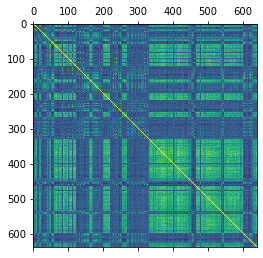

In [64]:
plt.matshow(spks_tmpmatrix['DH_EVAL_0011.wav'])

In [65]:
import pickle

In [66]:
with open('spks_tmpmatrix_t2_uem', 'wb') as f:
    pickle.dump(spks_tmpmatrix, f)

## Spectral Clustering with matprocessing (Optional)

In [67]:
from skimage import exposure
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from sklearn.preprocessing import normalize, minmax_scale

In [68]:
with open('spks_tmpmatrix_t2_uem', 'rb') as f:
    spks_tmpmatrix = pickle.load(f)

In [ ]:
## rescale

In [69]:
cutSample = None  # Size of matrix
lowValue = 40    # Set a low value for range rescale
highValue = 95   # Set a high value for range rescale

In [70]:
def post_process_matrix(sample, cut_sample=None, low_value=2, high_value=98, clip_limit=0.03, preprocess_orig='normalize', out_range=(0.1, 0.9)):
    for i in range(len(sample)):   
        sample[i][i] = 0.0
        
    if cut_sample is not None:
        sample = sample[:cut_sample, :cut_sample]
    
    if preprocess_orig == 'normalize':
        sample = normalize(sample)
    elif preprocess_orig == 'maxmin':
        sample = minmax_scale(sample)
    elif preprocess_orig == 'denoising':
        sigma_est = estimate_sigma(sample, average_sigmas=False)
        sample = denoise_wavelet(sample, method='BayesShrink', mode='soft', rescale_sigma=True)
        sample = denoise_wavelet(sample, method='VisuShrink', mode='soft', sigma=sigma_est/4, rescale_sigma=False)
    
    
    # scale with the designated lowest value and highest value. (best! with a high lowest threshold...)
    lowest, highest = numpy.percentile(sample, (low_value, high_value))
    
    sampleSced = exposure.rescale_intensity(sample, in_range=(lowest, highest), out_range=out_range)

    return sampleSced

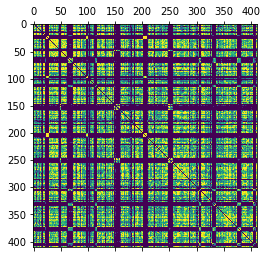

In [64]:
plt.matshow(inp_matrix)

In [74]:
preprocess_orig = None
perspk_clustering_result = {}
for count, i in enumerate(spks_tmpmatrix):
    inp_matrix = post_process_matrix(spks_tmpmatrix[i], cutSample, lowValue, highValue, clip_limit=0.1, preprocess_orig=preprocess_orig)
    
    perspk_clustering_result[i] = SC(inp_matrix)
    print(count, end='\r')

In [75]:
perspk_clustering_result['DH_EVAL_0001.wav']

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 2, 1, 0,
       0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 1,
       0, 2, 1, 0, 0, 1, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [ ]:
## denoise and rescale

In [201]:
cutSample = None  # Size of matrix
lowValue = 40    # Set a low value for range rescale
highValue = 95   # Set a high value for range rescale

In [161]:
preprocess_orig = 'denoising'
perspk_clustering_result = {}
for count, i in enumerate(spks_tmpmatrix):
    inp_matrix = post_process_matrix(spks_tmpmatrix[i], cutSample, lowValue, highValue, clip_limit=0.1, preprocess_orig=preprocess_orig, out_range=(0.1, 0.9))
    
    perspk_clustering_result[i] = SC(inp_matrix)
    print(count, end='\r')

In [167]:
perspk_clustering_result['DH_EVAL_0006.wav']

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Spectral Clustering

In [72]:
from sklearn.cluster import KMeans

In [73]:
def SC(inp_matrix):
    # 1 . Construct S and set diagonal elements to 0.
    for i in range(inp_matrix.shape[0]):
        inp_matrix[i][i] = 0.0
    # 2 . Compute Laplacian matrix L and perform normalization
    S = inp_matrix
    D = numpy.diag(numpy.sum(S, axis=1))
    L = D - S
    invsqrtD = numpy.diag(1.0 / (numpy.sum(S, axis=1) ** (0.5)))
    L_norm = numpy.dot(numpy.dot(invsqrtD, L), invsqrtD)
    # 3 . Compute eigenvalues and eigenvectors of L norm
    lam, H = numpy.linalg.eig(L_norm)
    
    # ADDED!
    try:
        lam = lam.real
        H = H.real
    except:
        pass
    
    # 4 . Take the k smallest eigenvalues
#     TH = 0.95
#    TH = 0.75
    TH = 0.85
    
    sort_index = numpy.argsort(lam)
    eig_vecs = []
    count = 0
    for i in sort_index:
        if (lam[i] > TH) and (count >= 2):
            break
        else:
            eig_vecs.append(H[:, i])
            count += 1

    for count, i in enumerate(eig_vecs):
        if count == 0:
            P = i[:, None]
        else:
            P = numpy.append(P, i[:, None], axis=1)
    # 5. Cluster row vectors y 1 , y 2 , ...y n of P to k classes by the K-means algorithm.            
    sp_kmeans = KMeans(n_clusters=P.shape[1]).fit(P)
    return sp_kmeans.labels_

In [79]:
perspk_clustering_result = {}
for count, i in enumerate(spks_tmpmatrix):
    inp_matrix = (spks_tmpmatrix[i] + 1.0) / 2.0
    perspk_clustering_result[i] = SC(inp_matrix)
    print(count)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258


In [80]:
perspk_clustering_result['DH_EVAL_0001.wav']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## combine detection result

In [76]:
answer_dict_tmpinsample3 = {}

In [77]:
for i in answer_dict_tmpinsample2:
    tmpinsample2 = answer_dict_tmpinsample2[i]
    matind2time = spks_matind2time[i]
    clustering_result = perspk_clustering_result[i]
    assert len(matind2time) == len(clustering_result)
    for j in matind2time:
        assert matind2time[j] in tmpinsample2.keys()
        tmpinsample2[matind2time[j]] = 'speaker'+str(clustering_result[j]+1)
    for k in tmpinsample2:
        assert tmpinsample2[k] != 'unknown'
    answer_dict_tmpinsample3[i] = tmpinsample2

In [78]:
answer_dict_tmpinsample3['DH_EVAL_0001.wav']

{'0.1120': 'speaker2',
 '1120.3520': 'silence',
 '3520.7520': 'speaker2',
 '7520.8480': 'silence',
 '8480.29920': 'speaker1',
 '29920.34240': 'silence',
 '34240.35360': 'speaker2',
 '35360.41600': 'silence',
 '41600.54080': 'speaker1',
 '54080.55520': 'silence',
 '55520.56960': 'speaker2',
 '56960.58880': 'silence',
 '58880.62240': 'speaker2',
 '62240.71680': 'silence',
 '71680.72800': 'speaker2',
 '72800.74880': 'silence',
 '74880.98880': 'speaker1',
 '86880.110880': 'speaker1',
 '98880.132320': 'speaker1',
 '132320.134080': 'silence',
 '134080.146720': 'speaker1',
 '146720.152800': 'silence',
 '152800.154080': 'speaker2',
 '154080.155680': 'silence',
 '155680.158720': 'speaker2',
 '158720.160960': 'silence',
 '160960.175520': 'speaker1',
 '175520.191840': 'silence',
 '191840.221920': 'speaker1',
 '221920.222720': 'silence',
 '222720.224320': 'speaker3',
 '224320.224960': 'silence',
 '224960.232000': 'speaker1',
 '232000.238400': 'silence',
 '238400.239520': 'speaker2',
 '239520.24432

## write DIHARD3 result

In [79]:
out_path = '/workspace/DATASET/server9_ssd/DIHARD3/track2_my'
import os
os.makedirs(out_path, exist_ok=True)

In [80]:
for i in answer_dict_tmpinsample3:
    out_rttm = os.path.join(out_path, i.split('.')[0]+'.rttm')
    answer_dict = answer_dict_tmpinsample3[i]
    with open(out_rttm, 'w') as out_f:
        for j in answer_dict:
            if answer_dict[j] == 'silence':
                continue
            start, end = j.split('.')
            start, end = float(start), float(end)
            out_start = start / 16000.0
            out_dur = (end - start) / 16000.0
            out_spk = answer_dict[j]
            
            outline = 'SPEAKER '+i.split('.')[0]+' 1 '+str(out_start)+' '+str(out_dur)+' <NA> <NA> '+out_spk+' <NA> <NA>\n'
            out_f.write(outline)

# FINISH

## SC TEST

In [ ]:
spks_tmpmatrix['DH_EVAL_0002.wav']

In [312]:
464 * 0.75

348.0

In [313]:
SC(spks_tmpmatrix['DH_EVAL_0099.wav'])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,

In [183]:
test = spks_tmpmatrix['DH_EVAL_0002.wav']

In [217]:
test = a

In [218]:
# 1 . Construct S and set diagonal elements to 0.
for i in range(test.shape[0]):
    test[i][i] = 0 

In [219]:
test = (test + 1.0) / 2.0

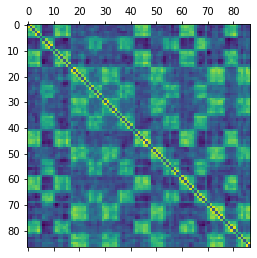

In [263]:
plt.matshow(test)

In [ ]:
# 2 . Compute Laplacian matrix L and perform normalization

In [221]:
S = test

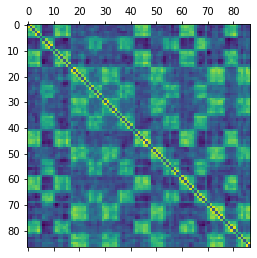

In [222]:
plt.matshow(S)

In [223]:
D = numpy.diag(numpy.sum(S, axis=1))
# L = D - S
# invsqrtD = numpy.diag(1.0 / (D ** (0.5)))

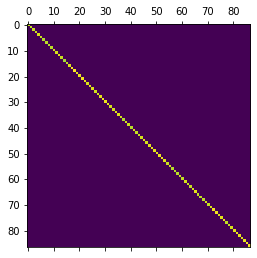

In [224]:
plt.matshow(D)

In [225]:
L = D - S

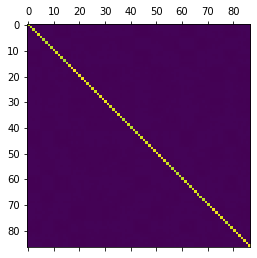

In [226]:
plt.matshow(L)

In [227]:
invsqrtD = numpy.diag(1.0 / (numpy.sum(S, axis=1) ** (0.5)))

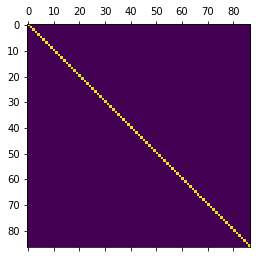

In [228]:
plt.matshow(invsqrtD)

In [229]:
L_norm = numpy.dot(numpy.dot(invsqrtD, L), invsqrtD)

In [146]:
L_norm

array([[ 0.998061  , -0.00265572, -0.00259667, ..., -0.00227694,
        -0.00274345, -0.00252973],
       [-0.00265572,  0.99770546, -0.00252585, ..., -0.0022359 ,
        -0.00228994, -0.00202126],
       [-0.00259667, -0.00252585,  0.9981911 , ..., -0.00207523,
        -0.00251628, -0.00263779],
       ...,
       [-0.00227694, -0.0022359 , -0.00207523, ...,  0.99778396,
        -0.00226047, -0.00224473],
       [-0.00274345, -0.00228994, -0.00251628, ..., -0.00226047,
         0.9981102 , -0.00287967],
       [-0.00252973, -0.00202126, -0.00263779, ..., -0.00224473,
        -0.00287967,  0.9982217 ]], dtype=float32)

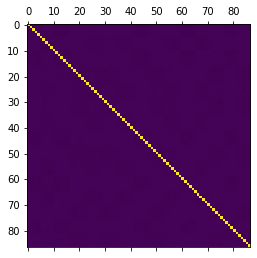

In [230]:
plt.matshow(L_norm)

In [ ]:
# 3 . Compute eigenvalues and eigenvectors of L norm

In [233]:
lam, H = numpy.linalg.eig(L_norm)

In [ ]:
# 4 . Take the k smallest eigenvalues

In [239]:
TH = 0.95

In [238]:
sort_index = numpy.argsort(lam)

In [251]:
eig_vecs = []
count = 0
for i in sort_index:
    if (lam[i] > TH) and (count >= 2):
        break
    else:
        eig_vecs.append(H[:, i])
        count += 1

In [252]:
len(eig_vecs)

3

In [253]:
for count, i in enumerate(eig_vecs):
    if count == 0:
        P = i[:, None]
    else:
        P = numpy.append(P, i[:, None], axis=1)

In [255]:
P.shape

(87, 3)

In [ ]:
# 5. Cluster row vectors y 1 , y 2 , ...y n of P to k classes by the K-means algorithm.

In [256]:
from sklearn.cluster import KMeans

In [257]:
sp_kmeans = KMeans(n_clusters=P.shape[1]).fit(P)

In [258]:
sp_kmeans.labels_

array([2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1],
      dtype=int32)

In [249]:
numpy.argsort(lam)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34,
       33, 35, 36, 37, 38, 42, 39, 40, 44, 43, 46, 47, 45, 41, 48, 49, 50,
       52, 53, 56, 57, 58, 64, 65, 66, 69, 70, 71, 82, 75, 86, 84, 83, 78,
       85, 79, 81, 77, 76, 74, 80, 72, 73, 68, 67, 63, 62, 61, 60, 59, 55,
       54, 51])

In [235]:
lam

array([4.4786397e-09, 8.4739274e-01, 8.9357841e-01, 9.8613226e-01,
       9.8741454e-01, 9.8946667e-01, 9.9155390e-01, 9.9200892e-01,
       9.9273103e-01, 9.9344206e-01, 9.9461895e-01, 9.9555182e-01,
       9.9599093e-01, 9.9719518e-01, 9.9756676e-01, 9.9837112e-01,
       9.9878883e-01, 9.9903166e-01, 9.9910104e-01, 1.0000265e+00,
       1.0007836e+00, 1.0009990e+00, 1.0016878e+00, 1.0017841e+00,
       1.0023711e+00, 1.0024955e+00, 1.0026860e+00, 1.0031492e+00,
       1.0033650e+00, 1.0034813e+00, 1.0036945e+00, 1.0042037e+00,
       1.0045958e+00, 1.0048553e+00, 1.0048259e+00, 1.0052845e+00,
       1.0054783e+00, 1.0056361e+00, 1.0059302e+00, 1.0064045e+00,
       1.0064979e+00, 1.0071779e+00, 1.0062410e+00, 1.0066791e+00,
       1.0066551e+00, 1.0070939e+00, 1.0068851e+00, 1.0069183e+00,
       1.0075563e+00, 1.0076665e+00, 1.0077138e+00, 1.0100204e+00,
       1.0078508e+00, 1.0079006e+00, 1.0099030e+00, 1.0098507e+00,
       1.0081165e+00, 1.0082214e+00, 1.0082814e+00, 1.0098048e

In [232]:
numpy.sort(lam)

array([4.4786397e-09, 8.4739274e-01, 8.9357841e-01, 9.8613226e-01,
       9.8741454e-01, 9.8946667e-01, 9.9155390e-01, 9.9200892e-01,
       9.9273103e-01, 9.9344206e-01, 9.9461895e-01, 9.9555182e-01,
       9.9599093e-01, 9.9719518e-01, 9.9756676e-01, 9.9837112e-01,
       9.9878883e-01, 9.9903166e-01, 9.9910104e-01, 1.0000265e+00,
       1.0007836e+00, 1.0009990e+00, 1.0016878e+00, 1.0017841e+00,
       1.0023711e+00, 1.0024955e+00, 1.0026860e+00, 1.0031492e+00,
       1.0033650e+00, 1.0034813e+00, 1.0036945e+00, 1.0042037e+00,
       1.0045958e+00, 1.0048259e+00, 1.0048553e+00, 1.0052845e+00,
       1.0054783e+00, 1.0056361e+00, 1.0059302e+00, 1.0062410e+00,
       1.0064045e+00, 1.0064979e+00, 1.0066551e+00, 1.0066791e+00,
       1.0068851e+00, 1.0069183e+00, 1.0070939e+00, 1.0071779e+00,
       1.0075563e+00, 1.0076665e+00, 1.0077138e+00, 1.0078508e+00,
       1.0079006e+00, 1.0081165e+00, 1.0082214e+00, 1.0082814e+00,
       1.0083729e+00, 1.0085541e+00, 1.0085931e+00, 1.0086586e

In [182]:
numpy.sort(lam)

array([2.8476741e-09, 9.1237485e-01, 9.7676313e-01, 9.8127234e-01,
       9.8547059e-01, 9.8677635e-01, 9.8861253e-01, 9.9077052e-01,
       9.9152815e-01, 9.9205428e-01, 9.9236959e-01, 9.9274659e-01,
       9.9328250e-01, 9.9403816e-01, 9.9409163e-01, 9.9433219e-01,
       9.9493587e-01, 9.9531543e-01, 9.9553543e-01, 9.9576741e-01,
       9.9611962e-01, 9.9622434e-01, 9.9641848e-01, 9.9651849e-01,
       9.9666852e-01, 9.9671590e-01, 9.9710733e-01, 9.9730867e-01,
       9.9734443e-01, 9.9753469e-01, 9.9759835e-01, 9.9779963e-01,
       9.9796551e-01, 9.9818027e-01, 9.9823505e-01, 9.9831599e-01,
       9.9845719e-01, 9.9855262e-01, 9.9860269e-01, 9.9884242e-01,
       9.9898505e-01, 9.9902338e-01, 9.9916667e-01, 9.9927562e-01,
       9.9938869e-01, 9.9952346e-01, 9.9955016e-01, 9.9963582e-01,
       9.9971181e-01, 9.9974734e-01, 9.9984413e-01, 9.9999416e-01,
       1.0000297e+00, 1.0000849e+00, 1.0001651e+00, 1.0002455e+00,
       1.0002701e+00, 1.0002747e+00, 1.0003376e+00, 1.0004072e

In [166]:
numpy.sort(lam)

array([-4.6559698e-09,  9.1497403e-01,  9.8222059e-01,  9.8516434e-01,
        9.8598576e-01,  9.8731369e-01,  9.8828369e-01,  9.8862481e-01,
        9.8897594e-01,  9.8923719e-01,  9.9012703e-01,  9.9035817e-01,
        9.9075460e-01,  9.9077725e-01,  9.9163491e-01,  9.9206102e-01,
        9.9230683e-01,  9.9269199e-01,  9.9305886e-01,  9.9318373e-01,
        9.9337590e-01,  9.9373370e-01,  9.9392366e-01,  9.9408263e-01,
        9.9434942e-01,  9.9439698e-01,  9.9464154e-01,  9.9475169e-01,
        9.9493241e-01,  9.9500781e-01,  9.9515527e-01,  9.9539399e-01,
        9.9546868e-01,  9.9567538e-01,  9.9576086e-01,  9.9601984e-01,
        9.9607325e-01,  9.9620193e-01,  9.9640048e-01,  9.9649835e-01,
        9.9657744e-01,  9.9671888e-01,  9.9680144e-01,  9.9694371e-01,
        9.9699271e-01,  9.9709362e-01,  9.9720150e-01,  9.9741763e-01,
        9.9747872e-01,  9.9757725e-01,  9.9771374e-01,  9.9775022e-01,
        9.9783081e-01,  9.9786752e-01,  9.9799442e-01,  9.9807411e-01,
      

In [149]:
lam

array([5.3661249e-09, 9.1917276e-01, 9.7256780e-01, 9.7595638e-01,
       9.8520732e-01, 9.8843867e-01, 9.8948437e-01, 9.9050230e-01,
       9.9111873e-01, 9.9203312e-01, 9.9216431e-01, 9.9246657e-01,
       9.9309498e-01, 9.9374926e-01, 9.9376744e-01, 9.9406004e-01,
       9.9434417e-01, 9.9466258e-01, 9.9474800e-01, 9.9480695e-01,
       9.9507874e-01, 9.9514925e-01, 9.9530858e-01, 9.9553466e-01,
       9.9571502e-01, 9.9584097e-01, 9.9595290e-01, 9.9599159e-01,
       9.9636400e-01, 9.9655122e-01, 9.9670064e-01, 9.9681050e-01,
       9.9701536e-01, 9.9707574e-01, 9.9718678e-01, 9.9729496e-01,
       9.9742103e-01, 9.9747884e-01, 9.9759316e-01, 9.9766493e-01,
       9.9770302e-01, 9.9784696e-01, 9.9871433e-01, 9.9794596e-01,
       9.9799323e-01, 9.9806565e-01, 9.9855179e-01, 9.9818593e-01,
       9.9843580e-01, 9.9839926e-01, 9.9831671e-01, 9.9825847e-01,
       9.9827164e-01, 9.9883360e-01, 9.9883002e-01, 9.9893039e-01,
       9.9898350e-01, 9.9902105e-01, 9.9905622e-01, 9.9913132e

In [93]:
lam

array([-4.9733373e-09,  2.8630891e-01,  8.0161315e-01,  8.7629050e-01,
        9.0049291e-01,  9.1896832e-01,  9.3420553e-01,  9.3635356e-01,
        1.0670176e+00,  9.4364369e-01,  1.0637361e+00,  9.4992453e-01,
        9.5220405e-01,  9.5537418e-01,  9.5725530e-01,  9.5863402e-01,
        1.0562971e+00,  9.6313030e-01,  1.0545038e+00,  1.0509717e+00,
        1.0488654e+00,  1.0478748e+00,  1.0462186e+00,  9.6710521e-01,
        9.6976817e-01,  9.7284538e-01,  9.7245663e-01,  1.0451232e+00,
        1.0437946e+00,  1.0436274e+00,  1.0419472e+00,  1.0403582e+00,
        1.0390488e+00,  1.0372237e+00,  1.0363269e+00,  1.0350640e+00,
        9.7404540e-01,  9.7516841e-01,  9.7813493e-01,  9.7925073e-01,
        9.8069787e-01,  9.8108441e-01,  9.8496306e-01,  9.8313683e-01,
        9.8340625e-01,  1.0340382e+00,  1.0330315e+00,  1.0326804e+00,
        1.0322307e+00,  1.0309823e+00,  1.0314858e+00,  9.8638701e-01,
        9.8583949e-01,  9.8763329e-01,  9.8867798e-01,  9.9004269e-01,
      

## test

In [12]:
from scipy.io import wavfile

In [281]:
sr, whole_wav = wavfile.read('/workspace/DATASET/server9_ssd/DIHARD3/DH_Female_Triple_mixdown.wav')

In [282]:
aa = {}
start = 0
end = seg_len
count = 0
while(True):
    aa[count] = str(start)+'.'+str(end)
    start = start + seg_hop
    end = end + seg_hop
    count += 1
    if end > len(whole_wav):
        break

In [283]:
# aa = spks_matind2time['DH_EVAL_0047.wav']
# whole_wav = raw_wav_dict['DH_EVAL_0047.wav']
embs = None
for i in range(len(aa)):
    start, end = aa[i].split('.')
    start, end = int(start), int(end)
    if embs is not None:
        embs = torch.cat([embs, audio2emb(whole_wav[start:end])], dim=0)
    else:
        embs = audio2emb(whole_wav[start:end])

In [284]:
embs_n = F.normalize(embs, p=2, dim=1)
a = embs_n.mm(embs_n.T)
a = a.numpy()

In [129]:
a = raw_wav_dict['DH_EVAL_0001.wav']

array([  5, -22, -61, ...,  -5,   3,   4], dtype=int16)

In [27]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

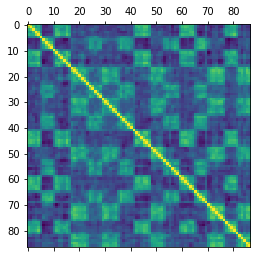

In [216]:
plt.matshow(a[:, :])

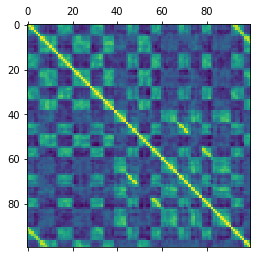

In [36]:
plt.matshow(a[:100, :100])

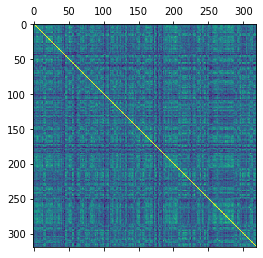

In [269]:
plt.matshow(a)

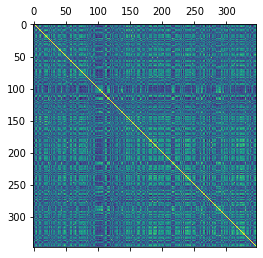

In [266]:
plt.matshow(a)

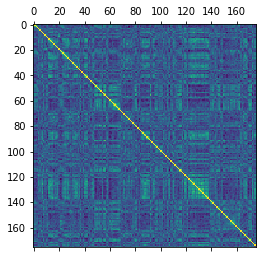

In [263]:
plt.matshow(a)

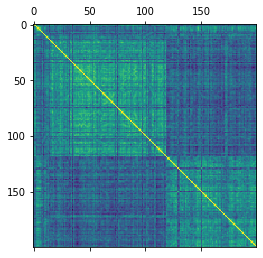

In [260]:
plt.matshow(a[:200, :200])

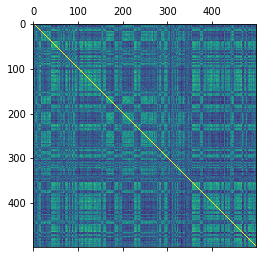

In [251]:
plt.matshow(a[:, :])

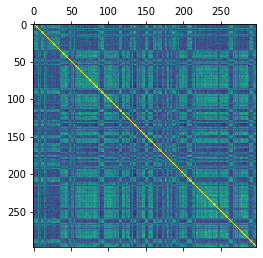

In [246]:
plt.matshow(a[:, :])

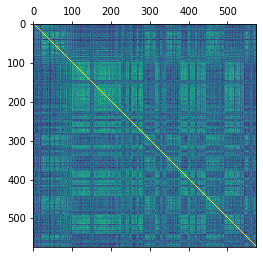

In [243]:
plt.matshow(a[:, :])

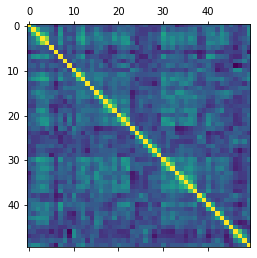

In [240]:
plt.matshow(a[:, :])

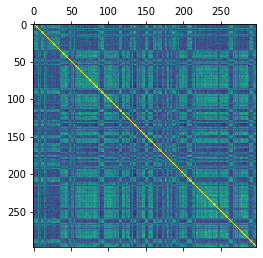

In [235]:
plt.matshow(a[:, :])

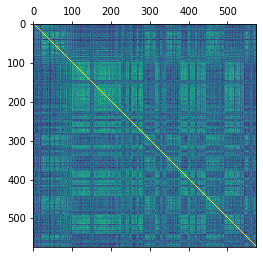

In [232]:
plt.matshow(a[:, :])

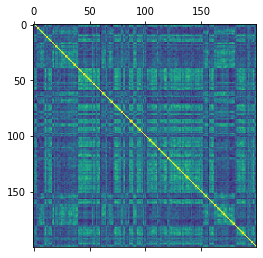

In [226]:
plt.matshow(a[:200, :200])

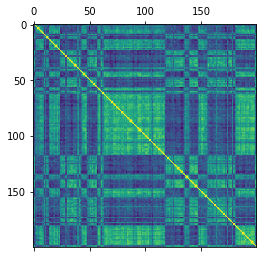

In [220]:
plt.matshow(a[:200, :200])

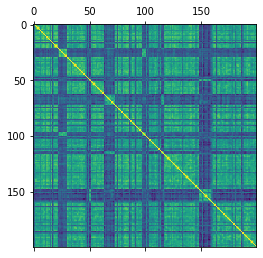

In [175]:
plt.matshow(a[0:200, 0:200])

In [131]:
b = answer_dict_tmpinsample2['DH_EVAL_0050.wav']

In [133]:
b['22560.39200']

'unknown'

In [141]:
audio = a[22560:39200]

In [142]:
audio.shape

(16640,)

In [144]:
ref_feat.shape

torch.Size([1, 192])

In [59]:
##test

['0.000\t1.555\tspeech\n',
 '2.290\t4.000\tspeech\n',
 '4.008\t8.414\tspeech\n',
 '9.892\t11.295\tspeech\n',
 '12.327\t15.847\tspeech\n',
 '16.109\t19.814\tspeech\n',
 '25.826\t31.435\tspeech\n',
 '31.553\t33.820\tspeech\n',
 '34.082\t35.270\tspeech\n',
 '35.496\t40.464\tspeech\n',
 '41.016\t43.067\tspeech\n',
 '43.298\t44.205\tspeech\n',
 '44.225\t47.286\tspeech\n',
 '48.193\t54.856\tspeech\n',
 '55.461\t56.340\tspeech\n',
 '56.541\t59.780\tspeech\n',
 '60.205\t63.260\tspeech\n',
 '64.088\t65.126\tspeech\n',
 '68.440\t69.327\tspeech\n',
 '69.696\t71.130\tspeech\n',
 '71.540\t72.087\tspeech\n',
 '72.116\t72.988\tspeech\n',
 '73.038\t77.642\tspeech\n',
 '77.977\t79.749\tspeech\n',
 '87.547\t88.249\tspeech\n',
 '92.324\t94.322\tspeech\n',
 '95.425\t95.882\tspeech\n',
 '96.528\t97.335\tspeech\n',
 '97.686\t98.711\tspeech\n',
 '99.628\t104.757\tspeech\n',
 '105.001\t105.744\tspeech\n',
 '105.863\t106.808\tspeech\n',
 '107.164\t108.652\tspeech\n',
 '115.696\t116.597\tspeech\n',
 '118.875\t1

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
for file in uems:
    with open(file, 'r') as f:
        line = f.readline()
    print(line)

DH_EVAL_0050 1 0.000 415.386

DH_EVAL_0007 1 0.000 599.952

DH_EVAL_0217 1 0.000 379.332

DH_EVAL_0128 1 0.000 363.169

DH_EVAL_0160 1 0.000 626.000

DH_EVAL_0190 1 0.000 30.622

DH_EVAL_0086 1 0.000 155.550

DH_EVAL_0102 1 0.000 13.716

DH_EVAL_0168 1 0.000 599.952

DH_EVAL_0175 1 0.000 608.150

DH_EVAL_0104 1 0.000 277.771

DH_EVAL_0116 1 0.000 178.515

DH_EVAL_0027 1 0.000 610.600

DH_EVAL_0223 1 0.000 17.394

DH_EVAL_0010 1 0.000 362.840

DH_EVAL_0029 1 0.000 599.952

DH_EVAL_0130 1 0.000 369.888

DH_EVAL_0011 1 0.000 599.952

DH_EVAL_0148 1 0.000 599.952

DH_EVAL_0122 1 0.000 603.746

DH_EVAL_0191 1 0.000 374.760

DH_EVAL_0083 1 0.000 97.541

DH_EVAL_0232 1 0.000 599.952

DH_EVAL_0040 1 0.000 583.528

DH_EVAL_0100 1 0.000 612.000

DH_EVAL_0056 1 0.000 616.000

DH_EVAL_0153 1 0.000 179.003

DH_EVAL_0037 1 0.000 614.500

DH_EVAL_0241 1 0.000 615.850

DH_EVAL_0094 1 0.000 384.575

DH_EVAL_0215 1 0.000 611.984

DH_EVAL_0132 1 0.000 258.160

DH_EVAL_0081 1 0.000 606.068

DH_EVAL_0228 1